In [218]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn.functional as F
from tqdm import tqdm
from MIOFlow.models import GrowthRateModel

In [220]:
# df = pd.read_csv("../../MIOFlow_growth_rate/data/data_dropped.csv")
# df0 = pd.read_csv("../data/mioflow_balanced_subsampled_growth.csv", index_col=0)
df0 = pd.read_csv("../data/mioflow_balanced_subsampled2.csv", index_col=0)
# df = pd.read_csv("../data/mioflow_balanced_subsampled_grown.csv", index_col=0)
scaler = StandardScaler()
# df[['d1', 'd2']] = scaler.fit_transform(df[['d1', 'd2']])
df = df0.copy()
df0[['d1', 'd2']] = scaler.fit_transform(df0[['d1', 'd2']])
growth = pd.read_csv("../data/growth_rate_alex.csv", index_col=0)

In [221]:
df0['growth'] = growth.loc[df0.index, 'growth'].clip(lower=0, upper=2)


In [222]:
max_t = df0['samples'].max()

Try not using kernel smoothing, see if network can smoothen it.

In [223]:
y_smooth = df0.loc[df0['samples']!=max_t, 'growth']

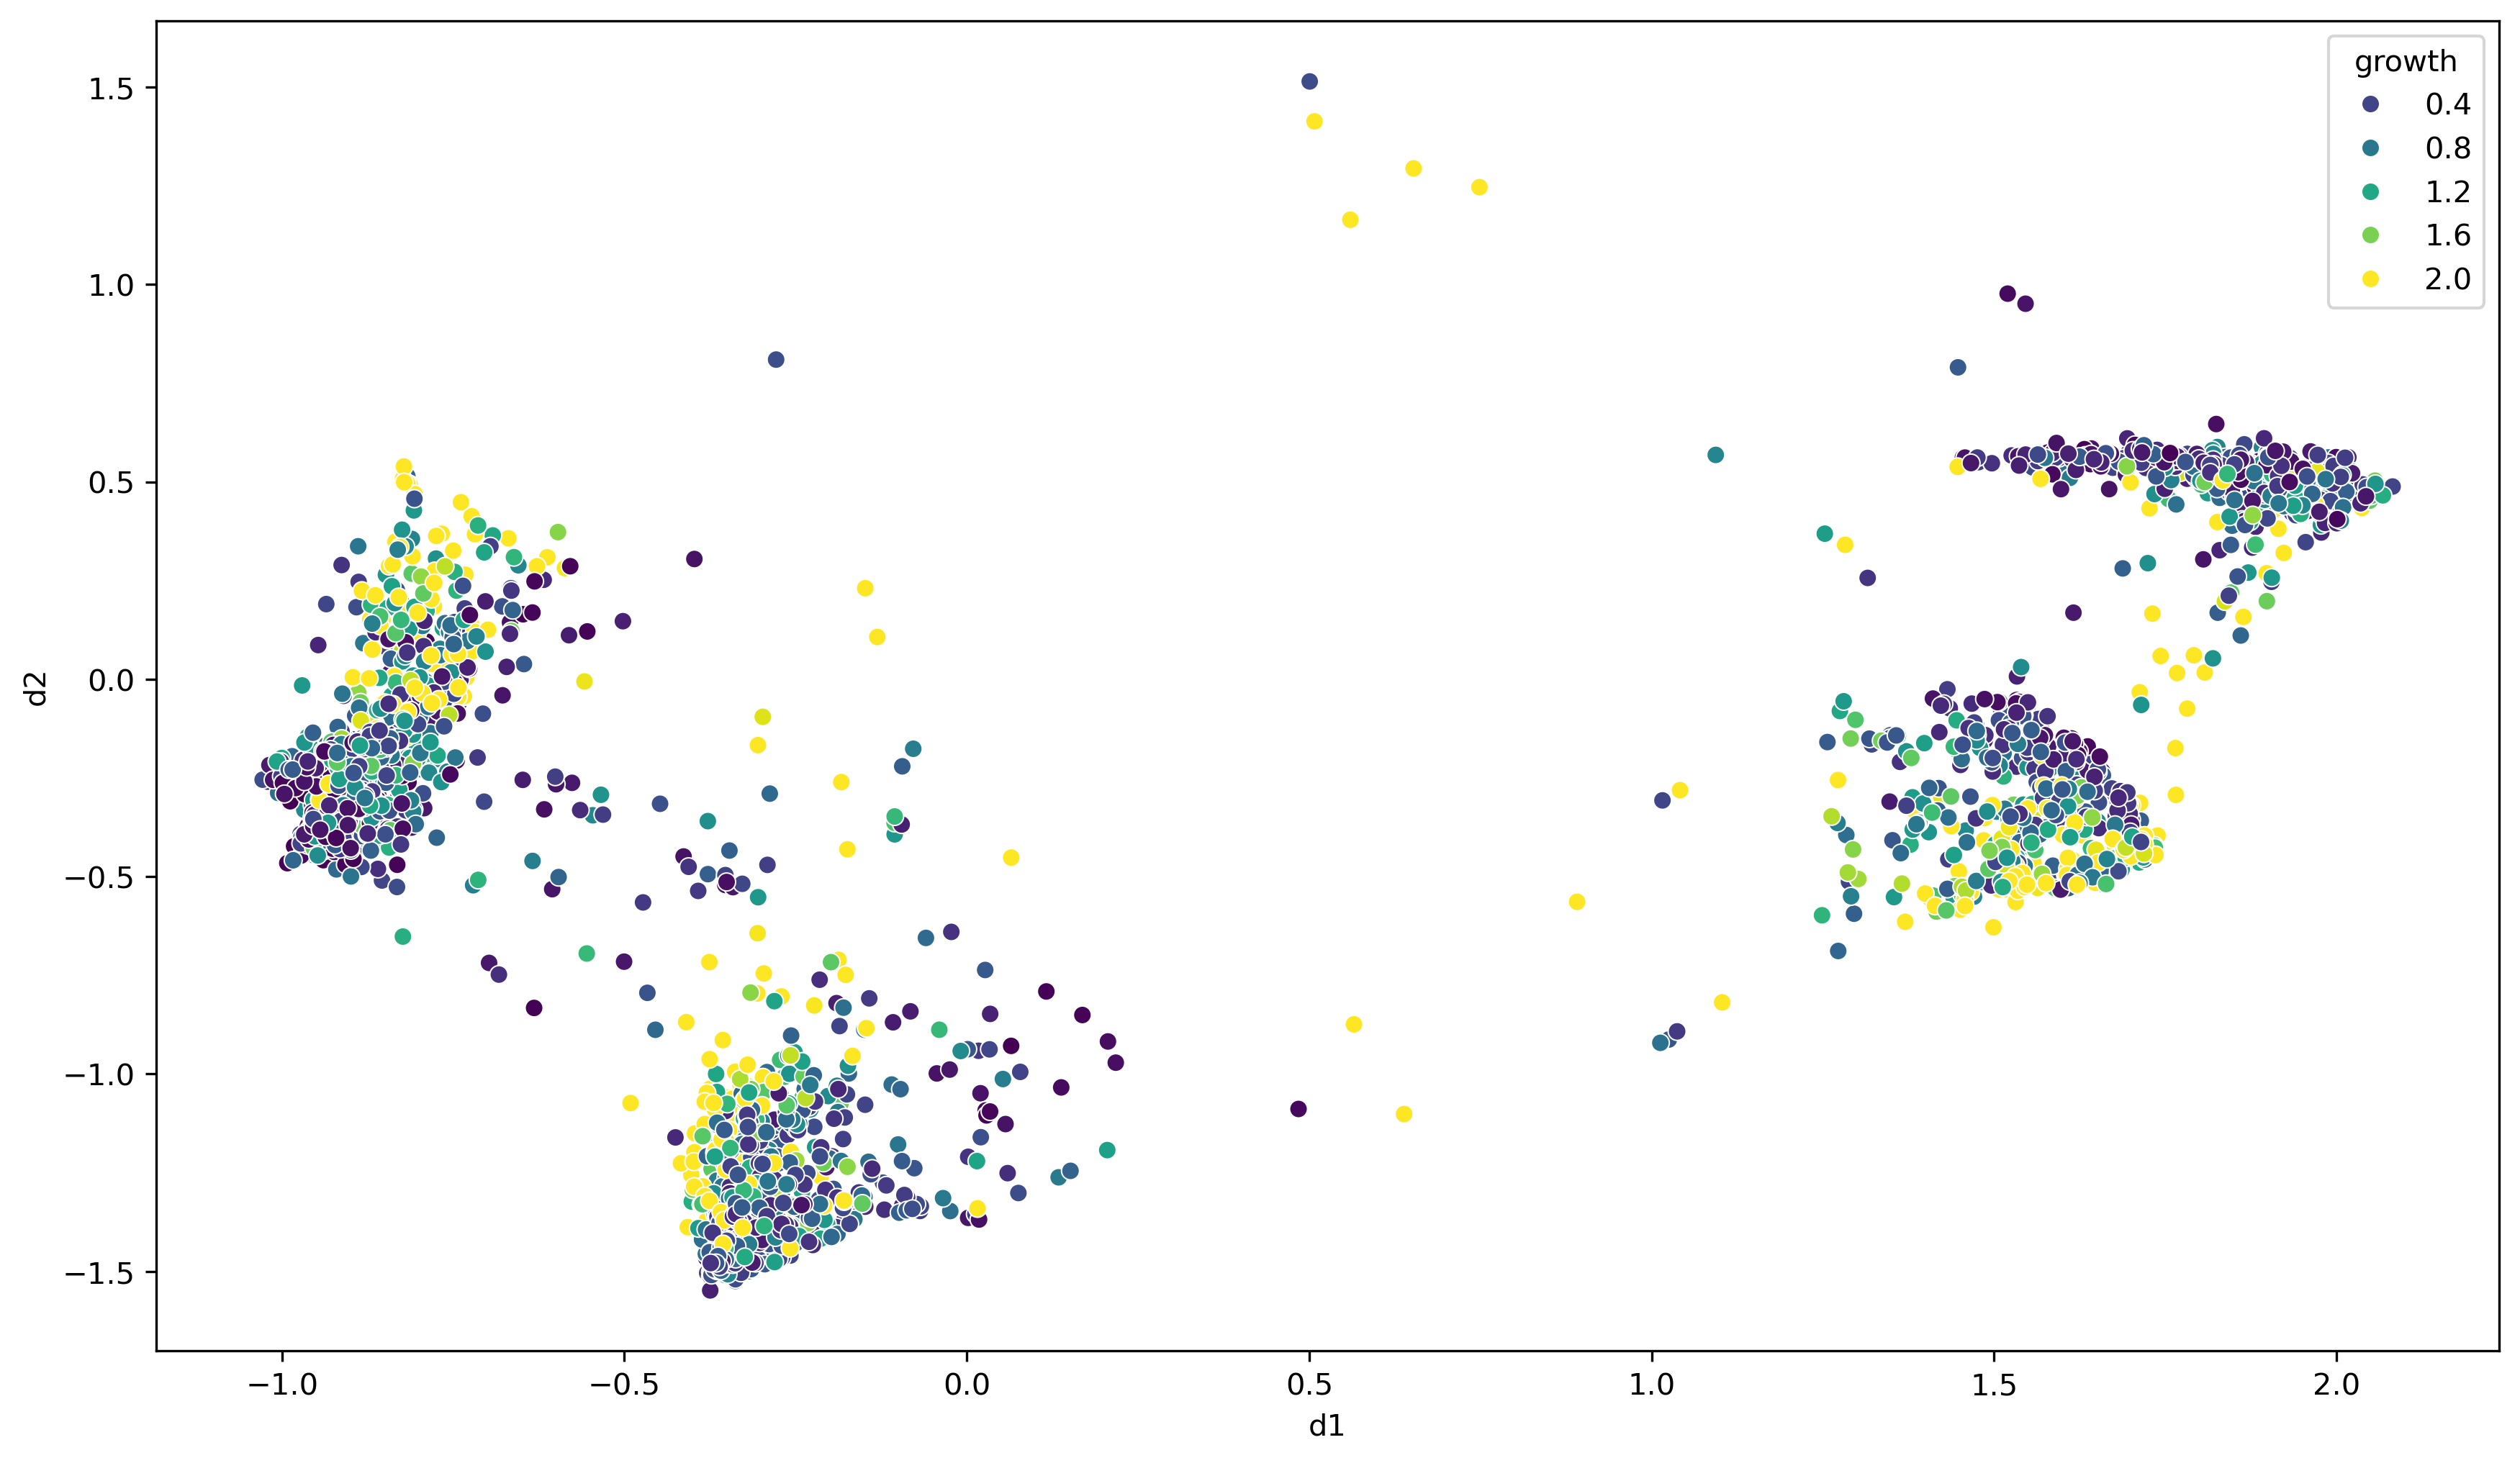

In [224]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(x=df0.loc[df0['samples']!=max_t, 'd1'], y=df0.loc[df0['samples']!=max_t, 'd2'], hue=y_smooth, palette='viridis');

In [225]:
df1 = df0.copy()
# df1['growth'] = np.nan
# df1.loc[df1['samples']!=max_t, 'growth'] = y_smooth
df1 = df1.drop(df1[df1['samples']!=max_t][df1.loc[df1['samples']!=max_t, 'growth'].isna()].index)

In [226]:
df1.to_csv("../data/growth_rate_smoothed2.csv")

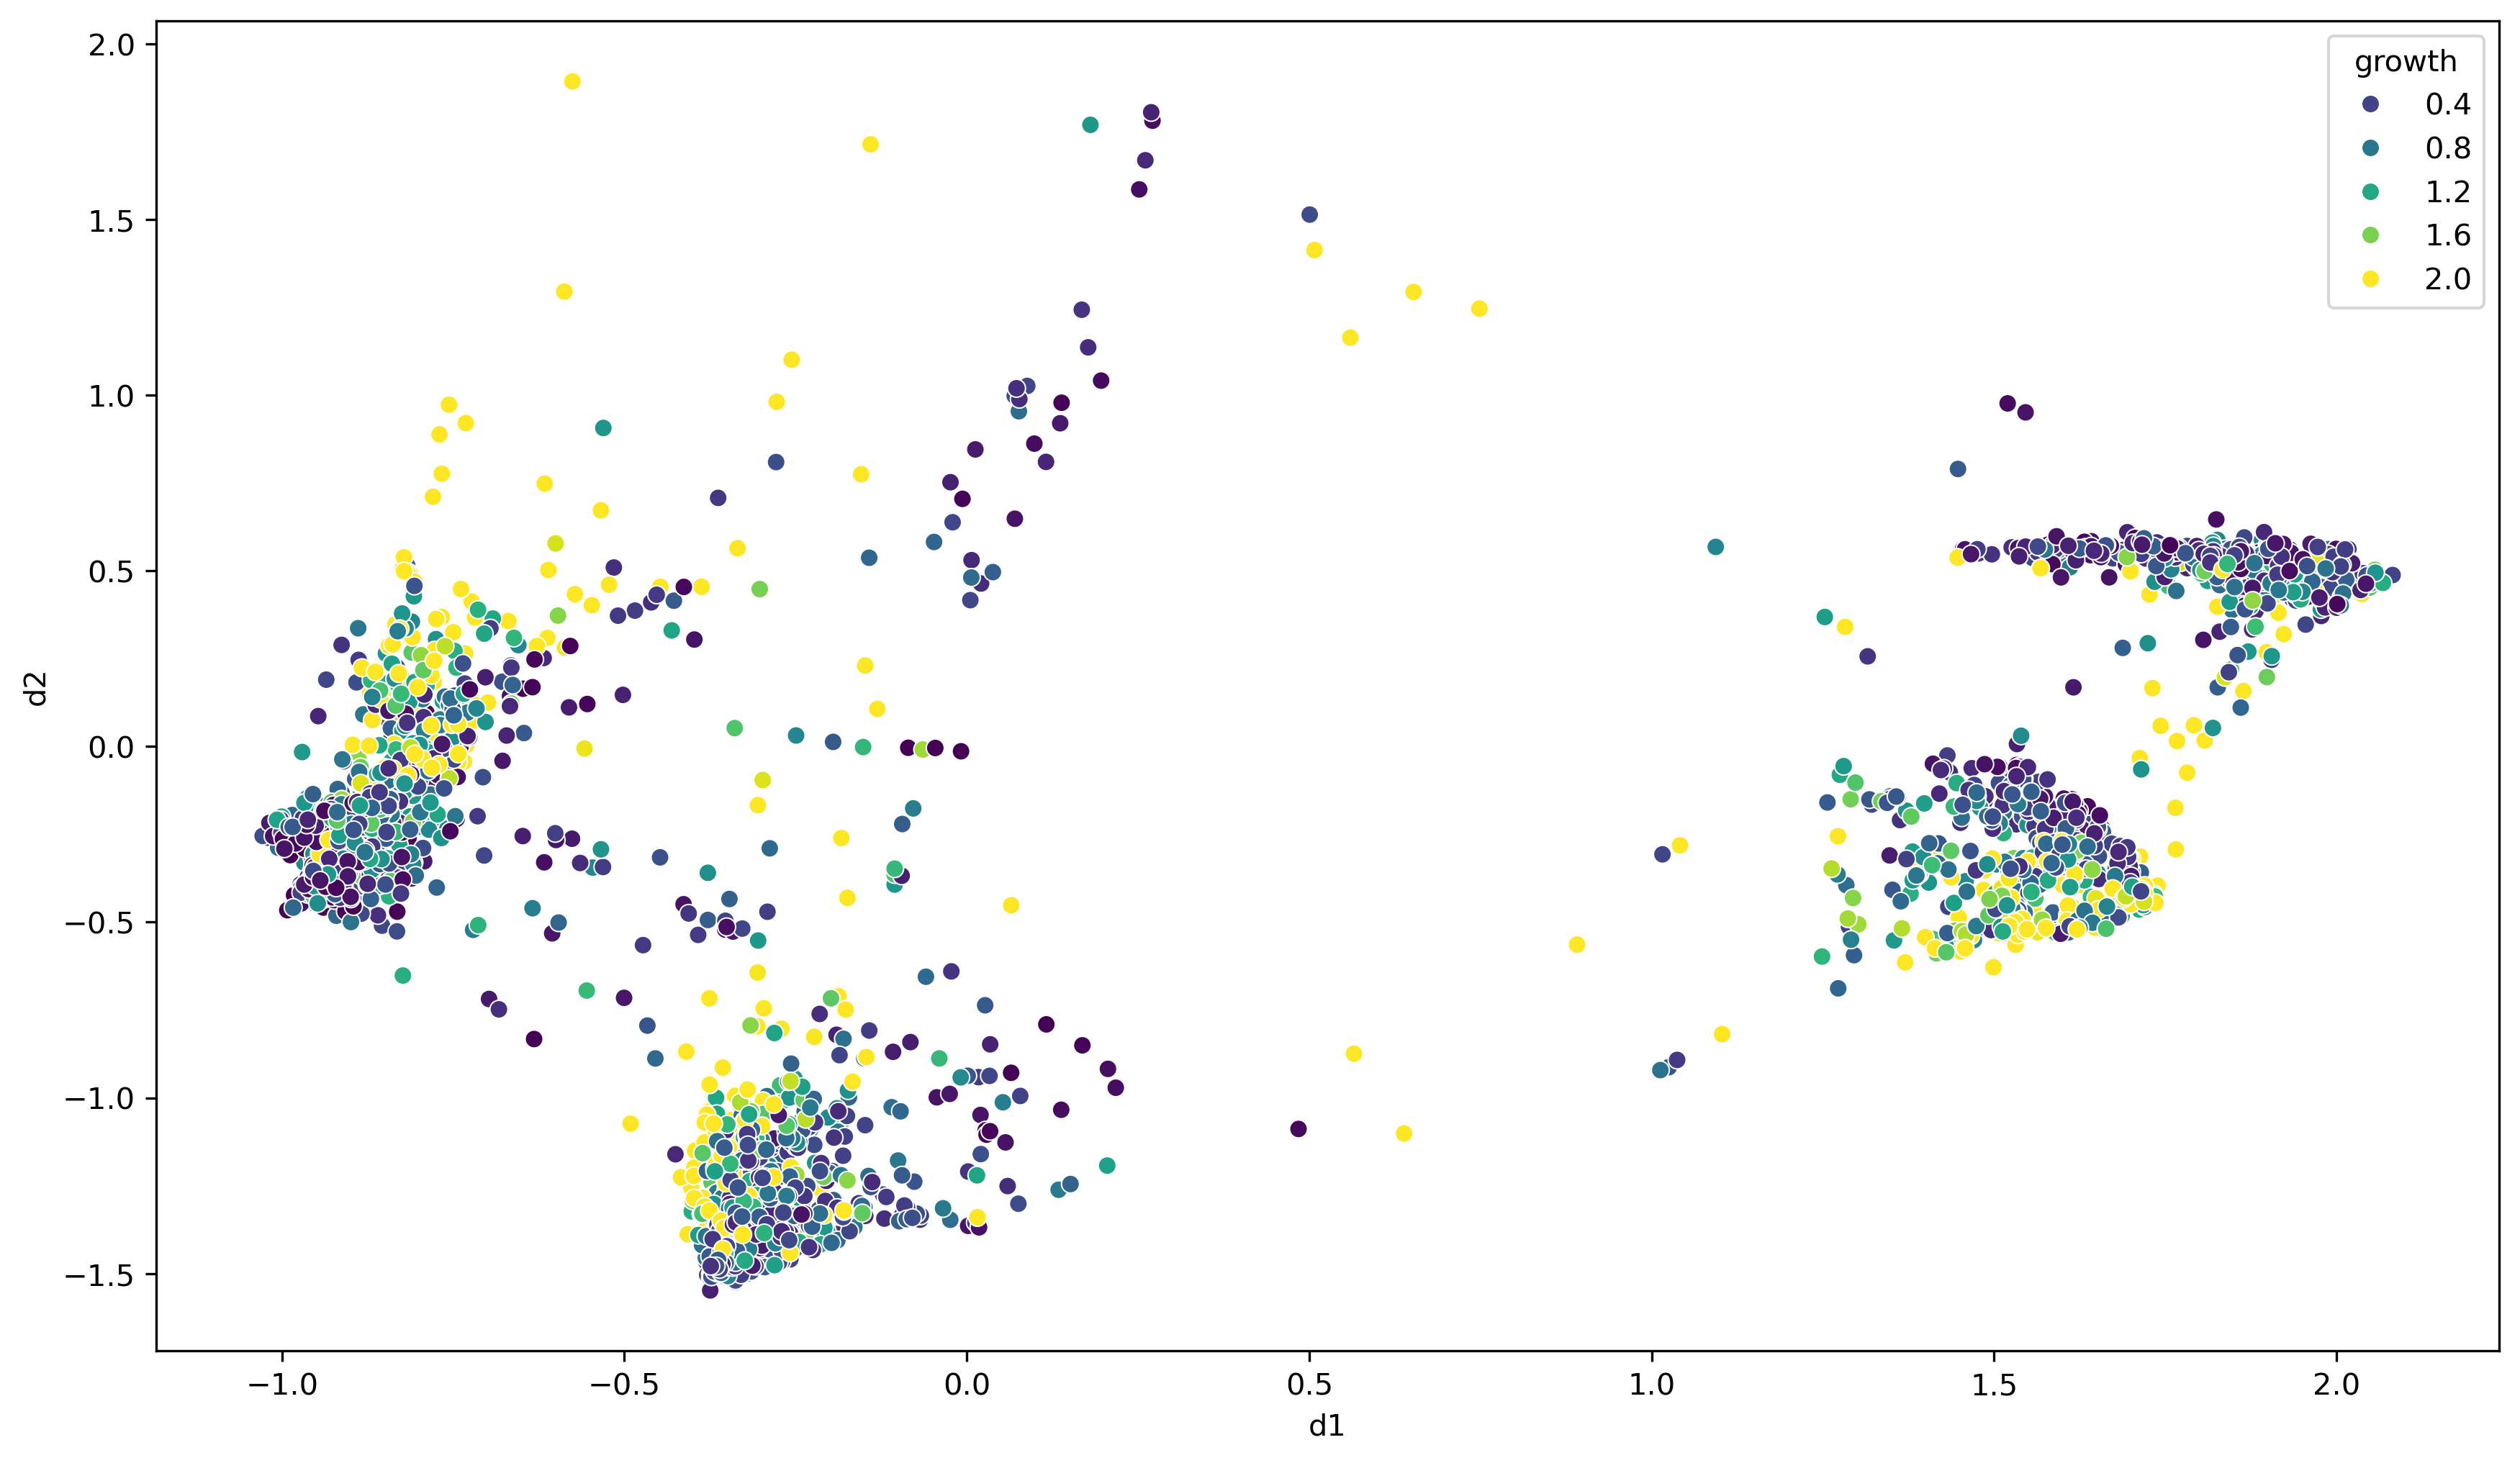

In [227]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df1, x='d1', y='d2', hue='growth', palette='viridis');

Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s, loss=0.2957]


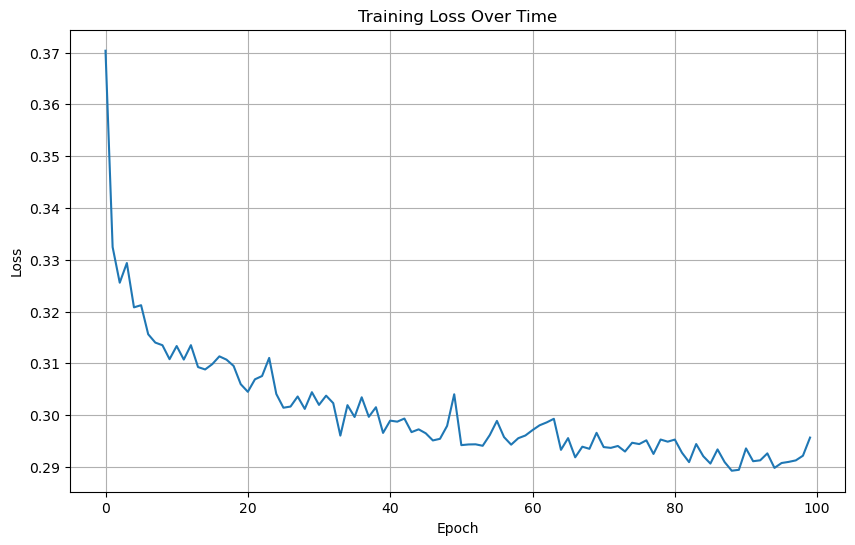

In [228]:
feature_dims = 2
condition_dims = 0
layers = [64, 32]
gmodel = GrowthRateModel(feature_dims, condition_dims, layers, use_time=False)
# train gmodel with sgd
data_x = torch.tensor(df1.loc[df1['samples']!=max_t, ['d1', 'd2']].values, dtype=torch.float32)
ys = df1.loc[df1['samples']!=max_t, 'growth'].values
gscaler = MinMaxScaler(feature_range=(0, 2))
ys = gscaler.fit_transform(ys[:, np.newaxis])
data_y = torch.tensor(ys, dtype=torch.float32)
optimizer = torch.optim.AdamW(gmodel.parameters(), lr=0.01)

# Create data loader
batch_size = 32
dataset = torch.utils.data.TensorDataset(data_x, data_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# List to store losses
losses = []

progress_bar = tqdm(range(100), desc='Epochs', position=0)
for epoch in progress_bar:
    epoch_loss = 0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        pred = gmodel(batch_x)
        loss = F.mse_loss(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

<Figure size 4200x2400 with 0 Axes>

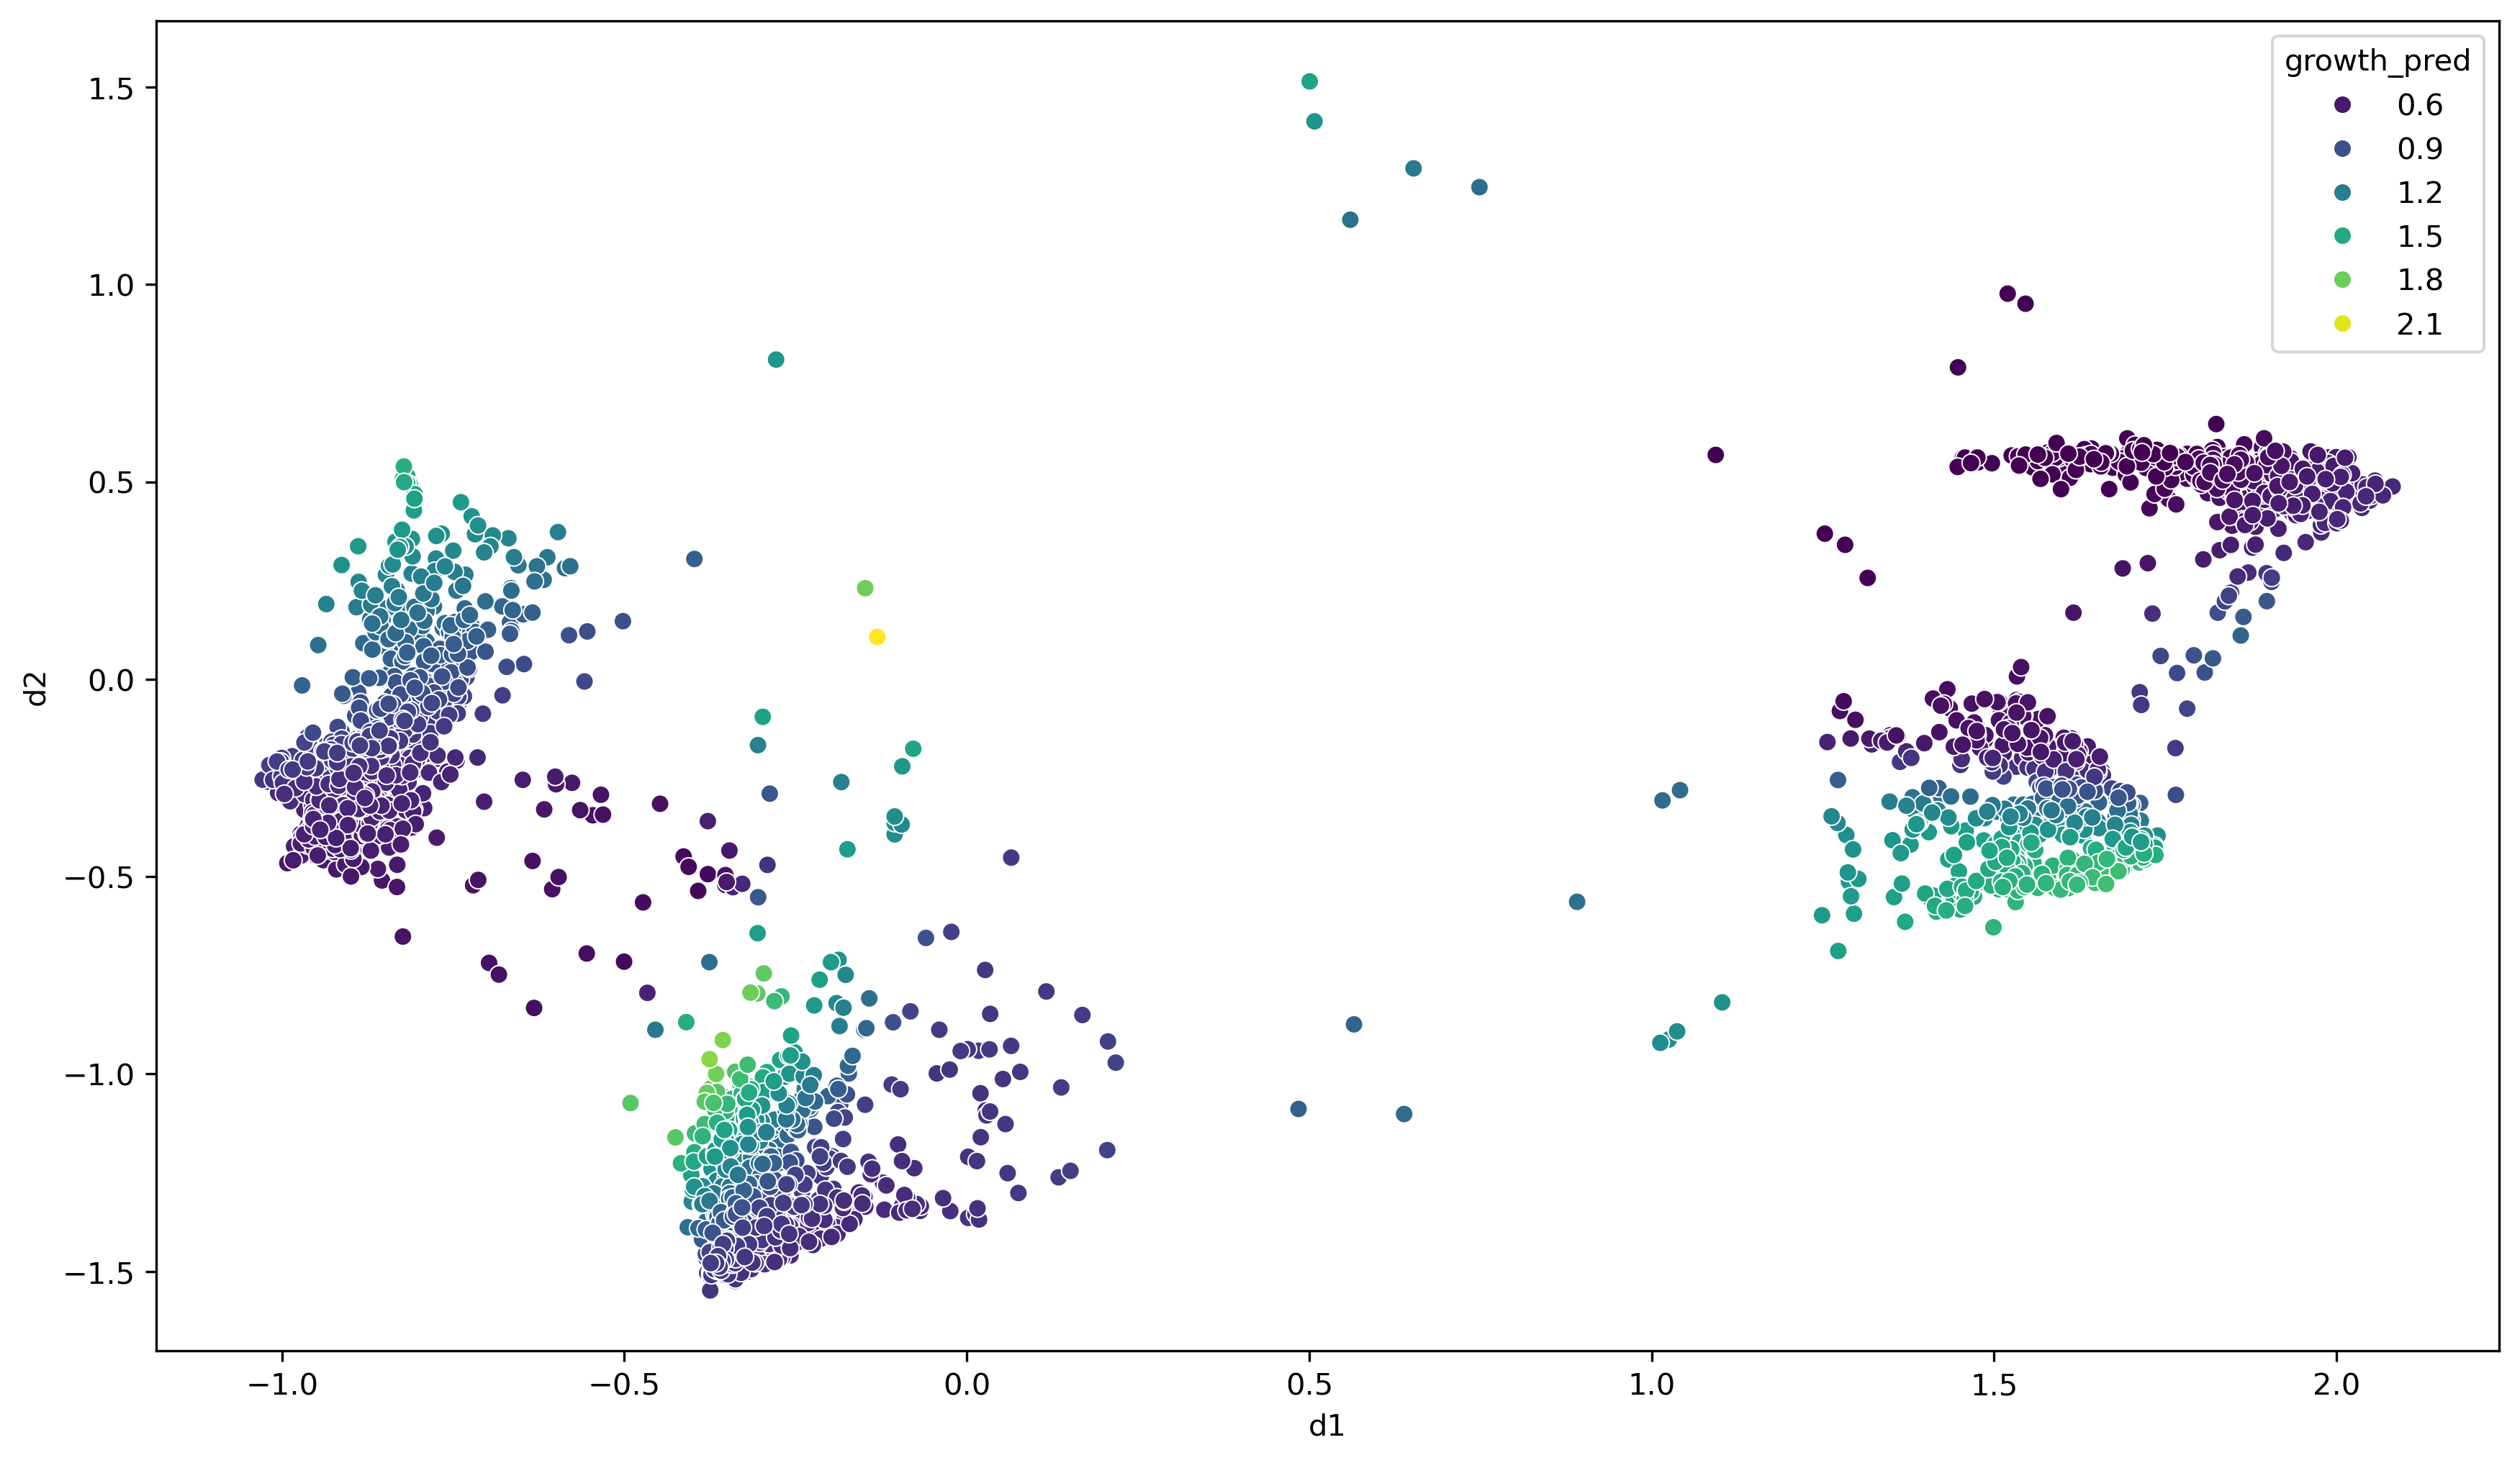

In [229]:
y_pred = gmodel(data_x).flatten().detach().numpy()
fig = plt.figure(figsize=(14, 8), dpi=300)
df2 = df1.copy()
df2['growth_pred'] = np.nan
df2.loc[df2['samples']!=max_t, 'growth_pred'] = y_pred
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df2, x='d1', y='d2', hue='growth_pred', palette='viridis');


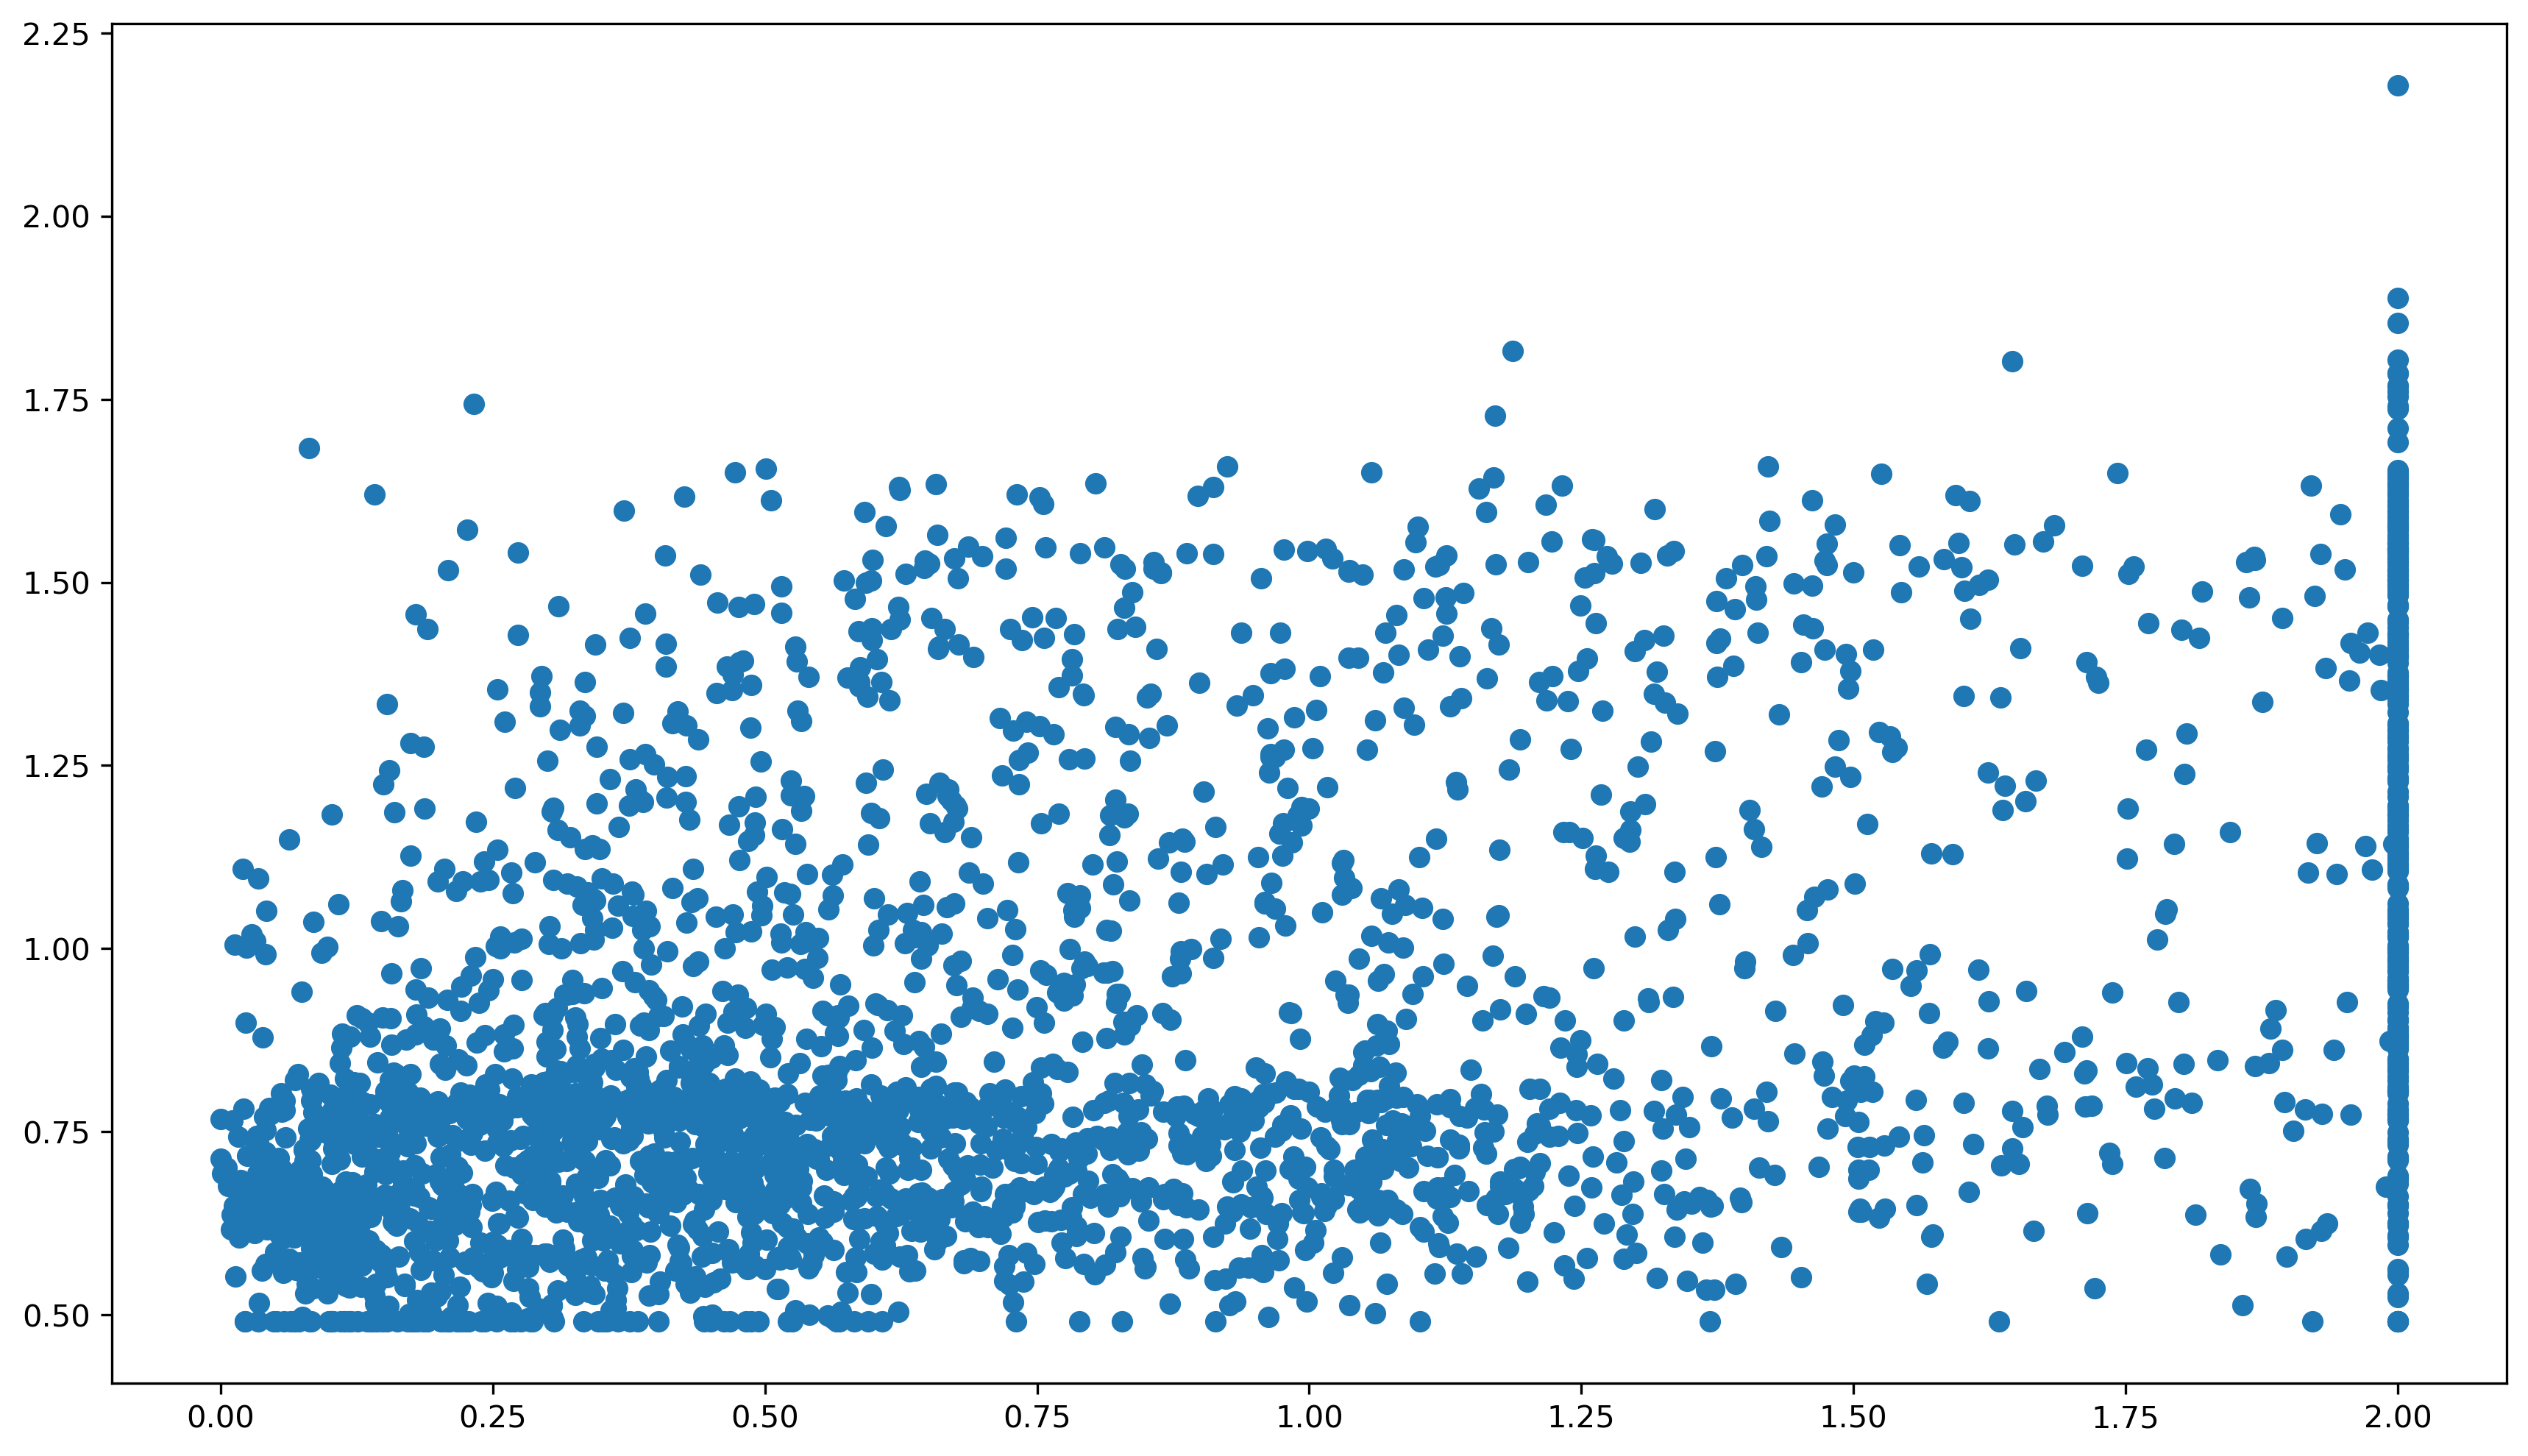

In [230]:
fig = plt.figure(figsize=(14, 8), dpi=300)
plt.scatter(data_y, y_pred);

In [231]:
# Save the trained model
torch.save(gmodel, 'gmodel_full2.pt')  # Save complete model
torch.save(gmodel.state_dict(), 'gmodel_state2.pt')  # Save model state dict

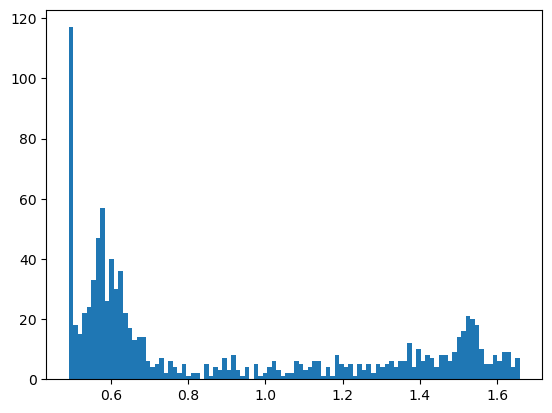

In [232]:
plt.hist(df2.loc[df2['samples']==0, 'growth_pred'], 100);

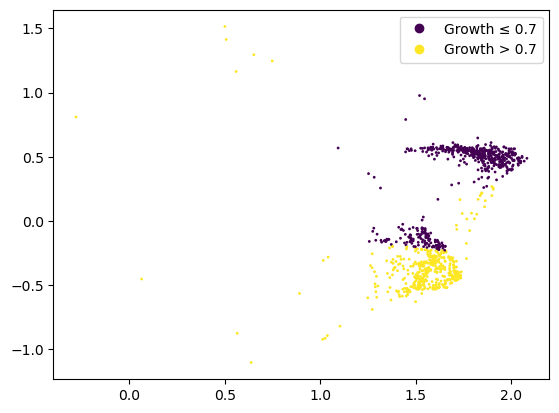

In [233]:
threshold = 0.7
scatter = plt.scatter(df2[df2['samples']==0]['d1'], df2[df2['samples']==0]['d2'], c=df2[df2['samples']==0]['growth_pred']>threshold, s=1)
plt.legend(scatter.legend_elements()[0], [f'Growth ≤ {threshold}', f'Growth > {threshold}'])


In [234]:
df2.to_csv("../data/growth_rate_smoothed_rescaled2.csv")